In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, classification_report, precision_recall_curve

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
# Cell 2
X_PATH = os.path.join("..", "data", "X_preprocessed.joblib")
y_PATH = os.path.join("..", "data", "y_preprocessed.joblib")

assert os.path.exists(X_PATH), f"X file not found: {X_PATH}"
assert os.path.exists(y_PATH), f"y file not found: {y_PATH}"

X = joblib.load(X_PATH)
y = joblib.load(y_PATH)

print("Loaded X, y shapes:", X.shape, y.shape)


Loaded X, y shapes: (1345310, 84) (1345310,)


In [3]:
RND = 42

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RND
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=RND
)

print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)


Shapes -> train: (968623, 84) val: (107625, 84) test: (269062, 84)


In [ ]:

scaler = StandardScaler()
scaler.fit(X_train)  

X_train_s = scaler.transform(X_train).astype(np.float32)
X_val_s   = scaler.transform(X_val).astype(np.float32)
X_test_s  = scaler.transform(X_test).astype(np.float32)


os.makedirs(os.path.join("..","models"), exist_ok=True)
joblib.dump(scaler, os.path.join("..","models","scaler.joblib"))

print("Scaled datasets. Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)


Scaled datasets. Shapes: (968623, 84) (107625, 84) (269062, 84)


In [ ]:
BATCH_SIZE = 2048

train_ds = TensorDataset(torch.from_numpy(X_train_s), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val_s), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test_s), torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [6]:

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256,128], dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        layers.append(nn.Sigmoid())  
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

model = MLP(input_dim=X_train_s.shape[1]).to(device)
print(model)


MLP(
  (net): Sequential(
    (0): Linear(in_features=84, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [8]:
# Cell 7 (fixed)
from collections import Counter
counter = Counter(y_train)
print("Train class counts:", counter)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2
)


Train class counts: Counter({np.int64(0): 775261, np.int64(1): 193362})


In [9]:
# Cell 8
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device).float()
        yb = yb.to(device).float()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        n += xb.size(0)
    return running_loss / n

def evaluate_model(model, loader):
    model.eval()
    preds_list = []
    ys_list = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            out = model(xb).cpu().numpy()
            preds_list.append(out)
            ys_list.append(yb.numpy())
    preds = np.concatenate(preds_list)
    ys = np.concatenate(ys_list)
    return preds, ys


In [10]:

N_EPOCHS = 12
best_auc = 0.0
best_path = os.path.join("..","models","best_mlp.pth")

for epoch in range(1, N_EPOCHS+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_preds, val_y = evaluate_model(model, val_loader)
    val_auc = roc_auc_score(val_y, val_preds)
    val_f1 = f1_score(val_y, (val_preds >= 0.5).astype(int))
    scheduler.step(val_auc)

    print(f"Epoch {epoch:02d} | train_loss: {train_loss:.4f} | val_auc: {val_auc:.4f} | val_f1@0.5: {val_f1:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), best_path)
        print("Saved best model.")


Epoch 01 | train_loss: 0.4606 | val_auc: 0.7156 | val_f1@0.5: 0.1250
Saved best model.
Epoch 02 | train_loss: 0.4535 | val_auc: 0.7190 | val_f1@0.5: 0.1117
Saved best model.
Epoch 03 | train_loss: 0.4521 | val_auc: 0.7206 | val_f1@0.5: 0.1364
Saved best model.
Epoch 04 | train_loss: 0.4514 | val_auc: 0.7206 | val_f1@0.5: 0.1279
Epoch 05 | train_loss: 0.4509 | val_auc: 0.7210 | val_f1@0.5: 0.1363
Saved best model.
Epoch 06 | train_loss: 0.4505 | val_auc: 0.7214 | val_f1@0.5: 0.1540
Saved best model.
Epoch 07 | train_loss: 0.4502 | val_auc: 0.7218 | val_f1@0.5: 0.1581
Saved best model.
Epoch 08 | train_loss: 0.4500 | val_auc: 0.7219 | val_f1@0.5: 0.1337
Saved best model.
Epoch 09 | train_loss: 0.4498 | val_auc: 0.7221 | val_f1@0.5: 0.1687
Saved best model.
Epoch 10 | train_loss: 0.4494 | val_auc: 0.7221 | val_f1@0.5: 0.1455
Saved best model.
Epoch 11 | train_loss: 0.4493 | val_auc: 0.7216 | val_f1@0.5: 0.1481
Epoch 12 | train_loss: 0.4492 | val_auc: 0.7220 | val_f1@0.5: 0.1391


In [11]:
# Cell 10
model.load_state_dict(torch.load(best_path, map_location=device))

test_preds, test_y = evaluate_model(model, test_loader)
test_auc = roc_auc_score(test_y, test_preds)
test_f1_05 = f1_score(test_y, (test_preds >= 0.5).astype(int))

print("Test AUC:", test_auc)
print("Test F1 @ 0.5:", test_f1_05)
print("\nClassification report @ 0.5:\n", classification_report(test_y, (test_preds>=0.5).astype(int), digits=4))


Test AUC: 0.7174826161407479
Test F1 @ 0.5: 0.14257650783342804

Classification report @ 0.5:
               precision    recall  f1-score   support

           0     0.8112    0.9838    0.8892    215350
           1     0.5570    0.0818    0.1426     53712

    accuracy                         0.8037    269062
   macro avg     0.6841    0.5328    0.5159    269062
weighted avg     0.7604    0.8037    0.7401    269062



In [12]:
val_preds_full, val_y_full = evaluate_model(model, val_loader)

thresholds = np.linspace(0.01, 0.99, 99)
best_thr = 0.5
best_f1 = 0.0
for thr in thresholds:
    f1 = f1_score(val_y_full, (val_preds_full >= thr).astype(int))
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("Best threshold on val by F1:", best_thr, "val_f1:", best_f1)

# Evaluate on test
test_pred_labels_best = (test_preds >= best_thr).astype(int)
test_f1_best = f1_score(test_y, test_pred_labels_best)
print(f"Test AUC: {test_auc:.4f} | Test F1 @ {best_thr:.2f}: {test_f1_best:.4f}")
print("\nClassification report @ best threshold:\n", classification_report(test_y, test_pred_labels_best, digits=4))


Best threshold on val by F1: 0.23 val_f1: 0.43840640667586395
Test AUC: 0.7175 | Test F1 @ 0.23: 0.4344

Classification report @ best threshold:
               precision    recall  f1-score   support

           0     0.8771    0.7083    0.7837    215350
           1     0.3398    0.6021    0.4344     53712

    accuracy                         0.6871    269062
   macro avg     0.6085    0.6552    0.6091    269062
weighted avg     0.7698    0.6871    0.7140    269062



In [13]:
os.makedirs(os.path.join("..","models"), exist_ok=True)

torch.save(model.state_dict(), os.path.join("..","models","final_mlp.pth"))
results = {
    "test_preds": test_preds,
    "test_y": test_y,
    "best_threshold": float(best_thr),
    "test_auc": float(test_auc),
    "test_f1_best": float(test_f1_best)
}
joblib.dump(results, os.path.join("..","models","test_results.joblib"))
print("Saved model and results to ../models/")


Saved model and results to ../models/


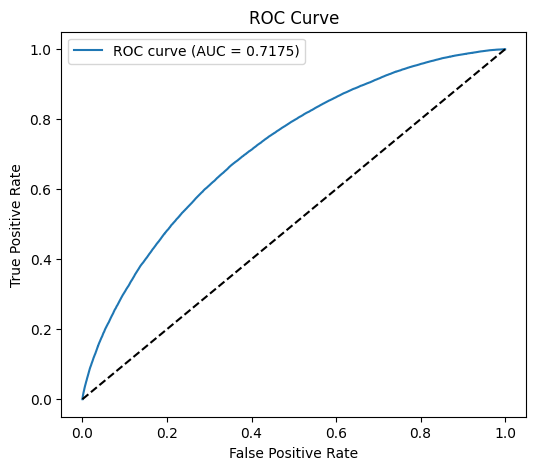

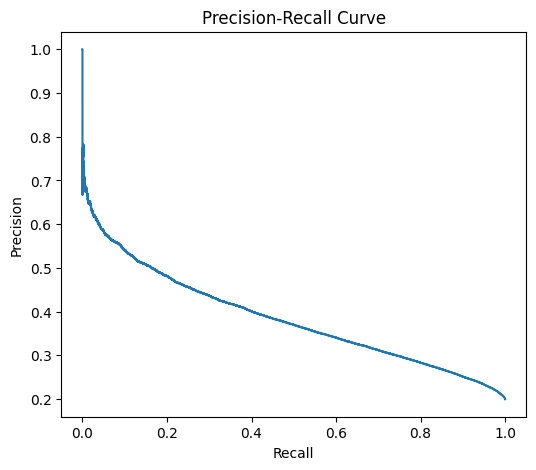

In [ ]:
fpr, tpr, _ = roc_curve(test_y, test_preds)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_val:.4f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(test_y, test_preds)
plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [15]:
# Cell 14
prob_and_label = pd.DataFrame({
    "prob": test_preds,
    "y": test_y
})

fn = prob_and_label[(prob_and_label['y']==1)].sort_values("prob").head(10)
fp = prob_and_label[(prob_and_label['y']==0)].sort_values("prob", ascending=False).head(10)

print("False negatives (actually default but predicted low prob):")
print(fn)

print("\nFalse positives (actually paid but predicted high prob):")
print(fp)


False negatives (actually default but predicted low prob):
            prob  y
26033   0.005769  1
36408   0.005778  1
250912  0.007472  1
7182    0.008580  1
224649  0.009659  1
130216  0.010579  1
52638   0.011127  1
166747  0.011389  1
178207  0.011399  1
99396   0.011984  1

False positives (actually paid but predicted high prob):
            prob  y
123609  0.801871  0
162126  0.800959  0
217610  0.782915  0
69817   0.779741  0
104921  0.775311  0
43210   0.769688  0
257625  0.768392  0
246660  0.764303  0
194149  0.752669  0
121393  0.751474  0
